# Installs and imports

In [ ]:
%pip install tick
%matplotlib inline

In [ ]:
import tick
import numpy as np
from time import time
import scipy.optimize as so
import matplotlib.pyplot as plt 
from tick.plot import plot_point_process
from tick.hawkes import SimuHawkes, HawkesKernelSumExp, SimuHawkesSumExpKernels, HawkesSumExpKern, HawkesKernelExp, HawkesKernelPowerLaw
import math
from scipy.fftpack import fft
from statistics import mean
from math import exp
import scipy.integrate as integrate
import random as random 
from time import time 


# Tick library




##Graph of a Hawkes process 



CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.60e-03 seconds.


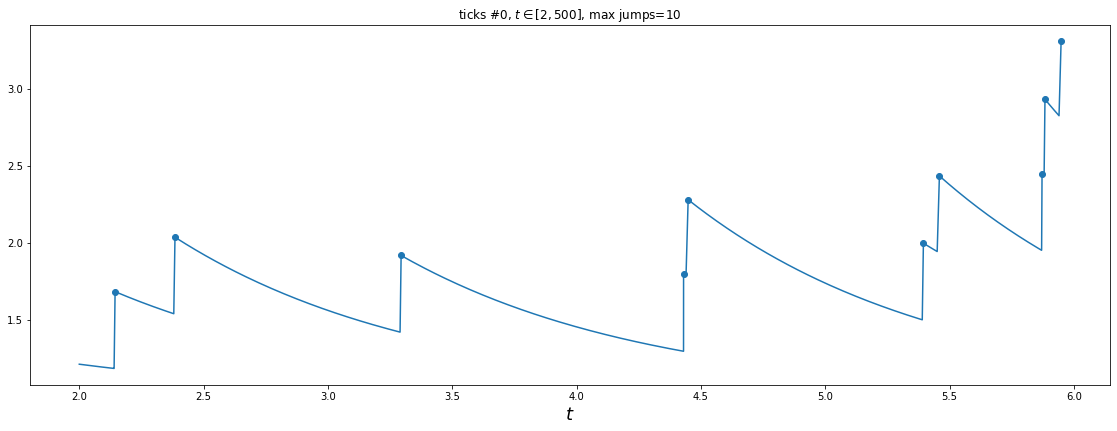

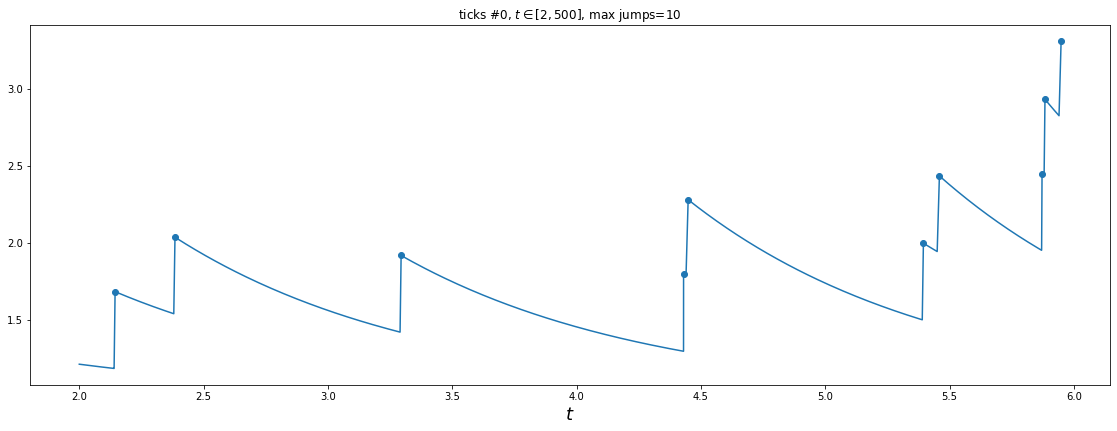

In [ ]:
"""
1 dimensional Hawkes process simulation
=======================================
"""
%time
baseline = np.array([1])
hawkes = SimuHawkes(baseline=baseline, end_time=500)
hawkes.set_kernel(0, 0, HawkesKernelExp(0.5, 1))

dt = 0.01
hawkes.track_intensity(dt)
hawkes.simulate()

fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plot_point_process(hawkes, n_points=50000, t_min=2, max_jumps=10, ax=ax)

## Generate a Hawkes process

In [ ]:
def proc_hawkes(mu, alpha, beta, end):
  baseline = np.array([mu])
  hawkes = SimuHawkes(baseline=baseline, end_time=end)
  hawkes.set_kernel(0, 0, HawkesKernelExp(alpha, beta))
  hawkes.simulate()
  return hawkes

#Implementing the Whittle estimation in Python 

## Periodogram

In [ ]:
def periodogram(counts):
  N = len(counts)
  dft = np.fft.fft(counts - np.mean(counts))
  I = np.abs(dft)**2 / N
  I = I[1:]
  return I 


## Cardinal Sine 

In [ ]:
def sinc(x):
    y = np.zeros(x.shape)
    for i, _ in enumerate(x):
        if x[i] == 0.0:
            y[i] = 1.0
        else:
            y[i] = np.sin(x[i]) / x[i]
    return y

## Exponential class

In [ ]:
class Exponential:
    def __init__(self, param, binsize):
        self.param = param
        self.binsize = binsize
        

    def mean(self):
      return (self.param[0] / (1.0 - self.param[1]))

    def H(self, xi):
      factor = self.param[1] * self.param[2] / (self.param[2]*self.param[2] + xi*xi)
      zeta = factor * self.param[2] -1j*factor * xi
      return zeta
    
    
    #G(w) = |1-H(w)|^{-2}
    def G(self, xi):
      return 1.0 / ( (1.0 - Exponential.H(self, xi)) * (1.0 - np.conj(Exponential.H(self, xi))) )

    #f(w) = m * binsize * sinc²(w/2) * G(w/binsize)

    def f(self, xi):
        term1 = sinc(.5 * xi)
        return Exponential.mean(self) * self.binsize * term1 * term1 * Exponential.G(self,  xi / self.binsize )
    
    #f1(w) = sum_{k=-trunc}^{+trunc} f(w + 2*k*pi)

    def f1(self, xi, trunc):
      omega = 2 * np.pi * np.arange(-trunc, trunc+1)
      y = np.zeros(xi.shape, dtype='complex')
      for k in range(xi.shape[0]):
        y[k] = np.sum(Exponential.f(self, xi[k] + omega))
      return y
    
    def whittle(self, periodogram, trunc,console_show=False):
      n = len(periodogram) + 1
      n2 = n // 2
      omega = 2.0 * np.pi * np.arange(1, n2 + 1) / float(n)
      spectrum = Exponential.f1(self, omega, trunc)
      if console_show:
        print(spectrum)
      return np.sum(np.log(spectrum) + periodogram[0:n2] / spectrum)

##Count series

In [ ]:

def discrete(hawkes, end, binsize):
    hist = np.histogram(hawkes, bins=np.arange(
        0, end+binsize, binsize), range=(0, end))
    return hist[0]


##The Whittle estimation

In [ ]:
def whittle(counts, binsize, trunc=5):
  #Periodogram
  N = len(counts)
  dft = np.fft.fft(counts - np.mean(counts))
  I = np.abs(dft)**2 / N
  I = I[1:]

  def nlopt_fn(param):
        expo = Exponential(param, binsize)
        return expo.whittle(I, trunc)

  ymean = np.mean(counts)

  wmin = np.inf
  param = np.array([0.0,0.0,0.0],dtype='float') # Performance comparison to do: float vs double vs uint8-16
  mu = 0.25
  rate = 1
  for mu_ in (.25, .5, .75):

    for rate_ in range(1, 6):
      param[0] = ymean * (1 - mu_)
      param[1] = mu_
      param[2] = rate_

      exp = Exponential(param, binsize)
      whit = exp.whittle(I, trunc = trunc)
 
      if whit < wmin:
        mu = mu_
        rate = rate_
        wmin = whit
  x0 = [ymean * (1 - mu), mu, rate]


  bnds = ((0.01, np.inf), (0.01, 0.99), (0.01, np.inf))
  opt = so.minimize(nlopt_fn, x0,method="L-BFGS-B", bounds = bnds)
    
  return opt['x']

Test for one Hawkes process: 

In [ ]:
hawkes = proc_hawkes(1,0.5,1, 500)
y = discrete(hawkes.timestamps, hawkes.end_time, binsize = 0.25)
start_time = time()
x = whittle(y, binsize = 0.25)
end_time = time()

In [ ]:
print("--- %s seconds for Whittle Estimation ---" % (end_time - start_time))
print ("mu=", x[0], ", alpha=", x[1], "and beta=", x[2])
print("true parameters: mu=", 1, "alpha=", 0.5, "beta=", 1.0)

--- 15.313445806503296 seconds for Whittle Estimation ---
mu= 1.0147751936624279 , alpha= 0.5124802816924322 and beta= 0.8142137746295304
true parameters: mu= 1 alpha= 0.5 beta= 1.0


**Remark:** On average, the Whittle estimates last 14 seconds for the set of parameters chosen. This is much longer than the results obtained with the hawkesbow library in R. We estimated our code is more or less 100 times longer. See more details in next section. However, a good point is that the estimate found is relatively close to the true parameters (see next sections and later for more details). 

# Python vs R: execution time 


In this section we compare execution times between Python and R for each portion of our code.

## Generate Hawkes processes


In [ ]:
def gen_hawkes():  
  l = []
  T = [100,200,400,800,1600,3200]
  for end in T:
    #A end fixé, on génère 100 processus de Hawkes
    debut = time()
    for j in range(100):
      hawkes = SimuHawkes(baseline = np.array([1]), end_time=end)
      hawkes.set_kernel(0, 0, HawkesKernelExp(.5, 1))
      hawkes.simulate()
    fin = time()
    l.append(fin-debut)
  return l

l =gen_hawkes()

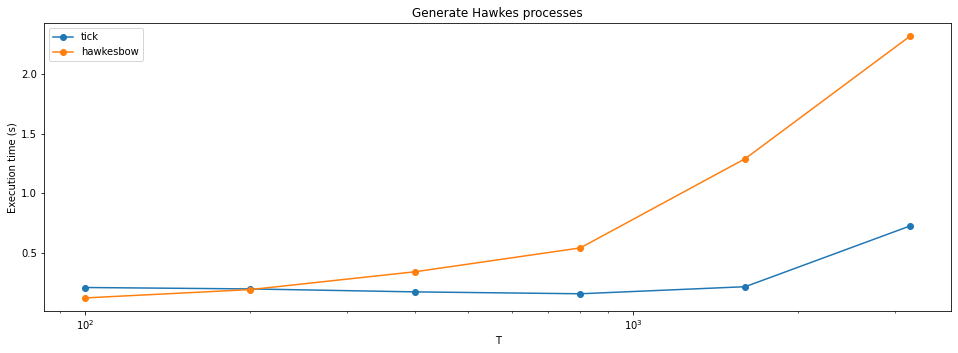

In [ ]:
#list of execution times with R
l_r = [0.12, 0.19, 0.34, 0.54, 1.29, 2.32]

T = [100,200,400,800,1600,3200]
fig1 = plt.figure(figsize=(18,5))
ax = fig1.add_axes([0.1, 0.1, 0.7, 0.8])
ax.plot(T, l, label="tick", marker='o')
ax.plot(T, l_r, label='hawkesbow', marker='o')
ax.set_title("Generate Hawkes processes")
ax.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('Execution time (s)')
plt.show()

**Graph:**

x-axis: end time T of the Hawkes process 

y-axis: time to execute 100 Hawkes processes

**Remarks:** As T increases, the execution time increases for the Hawkesbow library which seems consistent since there is more data to create. Surprinsingly, the execution time stays, at first, almost constant for the tick library as if the generation of Hawkes processes was independent of the end time T. This graph show that tick is much more performant than hawkesbow when it comes to generate Hawkes processes. 

## Generate the count series

In [ ]:
def perf_discrete():
  mat = np.zeros((3,6))
  temps = 0
  i, k = -1,-1
  for binsize in [0.25, 1, 2]:
    i+=1
    for end in [100,200,400,800,1600,3200]:
      k+=1
      #A end fixé, on génère 100 processus de Hawkes
      for j in range(100):
        hawkes = SimuHawkes(baseline = np.array([1]), end_time=end)
        hawkes.set_kernel(0, 0, HawkesKernelExp(.5, 1))
        hawkes.simulate()
        debut = time()
        discrete(hawkes.timestamps, end, binsize = binsize) 
        fin = time()
        temps += fin - debut
      mat[i][k] = temps
      temps = 0
    k = -1
  return mat

mat = perf_discrete()

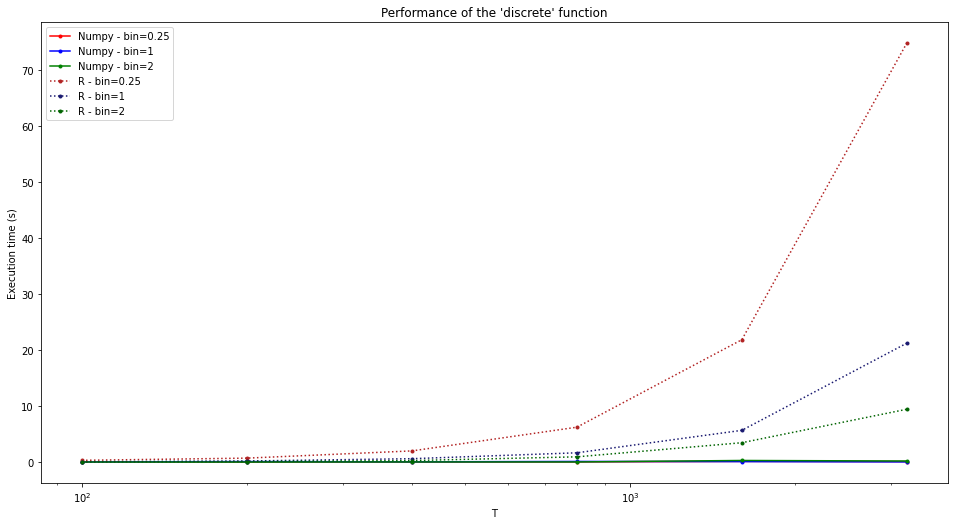

In [ ]:
#Résults obtained with R:
l = [0.32, 0.71, 2.0, 6.23, 21.84, 74.76]
l_1 = [0.07, 0.2, 0.61, 1.66, 5.67, 21.22]
l_2 = [0.05, 0.1, 0.28, 0.94, 3.46, 9.43]

T = [100,200,400,800,1600,3200]


fig1 = plt.figure(figsize=(18,8))
ax = fig1.add_axes([0.1, 0.1, 0.7, 0.8])
ax.plot(T, mat[0], label="Numpy - bin=0.25", marker='.', color='red')
ax.plot(T, mat[1], label="Numpy - bin=1", marker='.', color='blue')
ax.plot(T, mat[2], label="Numpy - bin=2", marker='.', color='green')

ax.plot(T, l, label="R - bin=0.25", marker='.', ls=':', color='firebrick')
ax.plot(T, l_1, label="R - bin=1", marker='.', ls=':', color='midnightblue')
ax.plot(T, l_2, label="R - bin=2", ls=':', marker='.', color='darkgreen')

ax.set_title("Performance of the 'discrete' function")
ax.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('Execution time (s)')
plt.show()

**Graph:**

x-axis: end time T of the Hawkes process 

y-axis: time to generate 100 count series of Hawkes processes 

**Remarks:** We clearly see how the execution time increases as the binsize decreases in R. However, the execution time stays constant whatever the binsize in Python. We can conlude that Numpy is really efficient and faster than R. 

##Generate the periodogram

In [ ]:
def perf_periodogram():
  mat = np.zeros((3,6))
  temps = 0
  i, k = -1,-1
  for binsize in [0.25, 1, 2]:
    i+=1
    for end in [100,200,400,800,1600,3200]:
      k+=1
      #A end fixé, on génère 100 processus de Hawkes
      for j in range(1000):
        hawkes = SimuHawkes(baseline = np.array([1]), end_time=end)
        hawkes.set_kernel(0, 0, HawkesKernelExp(.5, 1))
        hawkes.simulate()
        counts = discrete(hawkes.timestamps, end, binsize = binsize)

        #Periodogramme
        debut = time()
        n = len(counts)
        dft = np.fft.fft(counts - np.mean(counts))
        I = abs(dft)**2 / n
        I = I[:-1]
        fin = time()
        
        temps += fin - debut
      mat[i][k] = temps
      temps = 0
    k = -1
  return mat
  mat_perio = perf_periodogram()

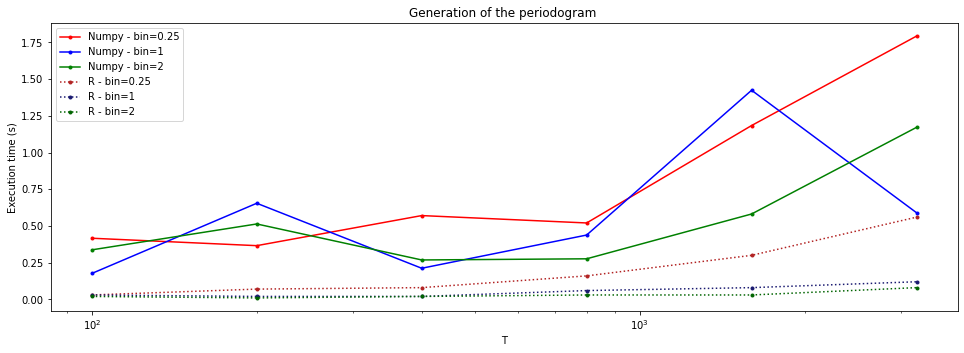

In [ ]:
T = [100,200,400,800,1600,3200]

#Résults obtained in R

l = [0.03, 0.07, 0.08, 0.16, 0.30, 0.56]
l_1 = [0.03, 0.02, 0.02, 0.06, 0.08, 0.12]
l_2 = [0.02, 0.01, 0.02, 0.03, 0.03, 0.08]


fig1 = plt.figure(figsize=(18,5))
ax = fig1.add_axes([0.1, 0.1, 0.7, 0.8])
ax.plot(T, mat_perio[0], label="Numpy - bin=0.25", marker='.', color='red')
ax.plot(T, mat_perio[1], label="Numpy - bin=1", marker='.', color='blue')
ax.plot(T, mat_perio[2], label="Numpy - bin=2", marker='.', color='green')

ax.plot(T, l, label="R - bin=0.25", marker='.', ls=':', color='firebrick')
ax.plot(T, l_1, label="R - bin=1", marker='.', ls=':', color='midnightblue')
ax.plot(T, l_2, label="R - bin=2", ls=':', marker='.', color='darkgreen')

ax.set_title("Generation of the periodogram ")
ax.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('Execution time (s)')
plt.show()

**Graph:**

x-axis: end time T of the Hawkes process 

y-axis: time to generate 100 count series of Hawkes processes

**Remarks:** R is quicker than Numpy when it comes to generate the periodogram: it seems that the Fast Fourier Transform (FFT) is better implemented in R than in Numpy.  


##The Whittle estimation

In [ ]:
def perf_whittle():
  mat = np.zeros((3,6))
  temps = 0
  i, k = -1,-1
  for binsize in [0.25, 1, 2]:
    i+=1
    for end in [100,200,400,800,1600,3200]:
      k+=1
      #A end fixé, on génère 100 processus de Hawkes
      for j in range(1):
        hawkes = SimuHawkes(baseline = np.array([1]), end_time=end)
        hawkes.set_kernel(0, 0, HawkesKernelExp(.5, 1))
        hawkes.simulate()
        y = discrete(hawkes.timestamps, end, binsize = binsize) 
        debut = time()
        whittle(y, binsize)
        fin = time()
        temps += fin - debut
      mat[i][k] = temps
      temps = 0
    k = -1
  return mat

mat_whittle = perf_whittle()

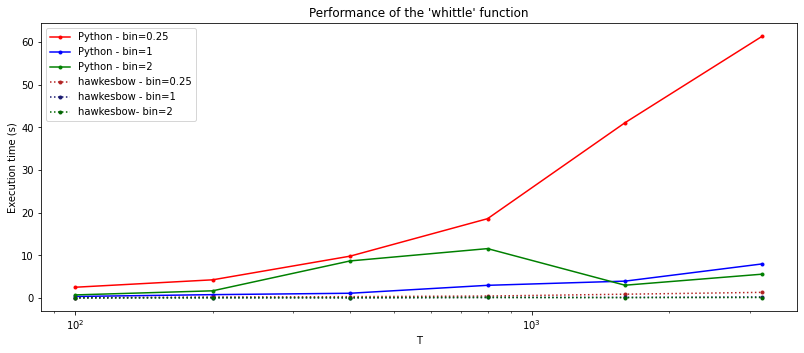

In [ ]:
fig = plt.figure(figsize=(15,5))

#Résults obtained with R
l = [6.36/100, 21.64/100, 30.47/100, 44.83/100, 87.82/100, 131.48/100]
l_1 = [2.58/100, 8.74/100, 3.36/100, 11.80/100, 14.25/100, 22.62/100]
l_2 = [1.11/100, 2.22/100, 6.06/100, 11.40/100, 7.21/100, 10.48/100]

ax = fig.add_axes([0.1, 0.1, 0.7, 0.8])
ax.plot(T, mat_whittle[0], label="Python - bin=0.25", marker='.', color='red')
ax.plot(T, mat_whittle[1], label="Python - bin=1", marker='.', color='blue')
ax.plot(T, mat_whittle[2], label="Python - bin=2", marker='.', color='green')

ax.plot(T, l, label="hawkesbow - bin=0.25", marker='.', ls=':', color='firebrick')
ax.plot(T, l_1, label="hawkesbow - bin=1", marker='.', ls=':', color='midnightblue')
ax.plot(T, l_2, label="hawkesbow- bin=2", ls=':', marker='.', color='darkgreen')

ax.set_title("Performance of the 'whittle' function")
ax.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('Execution time (s)')
plt.show()

**Graph:**

x-axis: end time T of the Hawkes process 

y-axis: time to estimate 1 Hawkes process

**Remark:**
The R code is very performant compared to our Python implementation. For T = 3200 it goes 80 times faster. We think this could come from the code's pre-compilation since R uses C++ to go faster. However, our 100% C++ implementation of the Whittle estimation has a comparable time execution with the Python one. Thus, we are not sure from where such time difference could come from. Our code is probably not coded in an optimal manner... 

# Precision boxplots of the Whittle estimation

In this section we exclusively study our Python implementation of the Whittle estimation 

In [ ]:
List_of_binsize= [0.125, 0.25, 0.5, 1, 2] # Liste des tailles de bin
end = 100 # Temps de fin
N = 50 # Number of simulations

Results = {0.125:{'mu':[],'alpha':[],'beta':[]},0.25:{'mu':[],'alpha':[],'beta':[]},0.5:{'mu':[],'alpha':[],'beta':[]},1:{'mu':[],'alpha':[],'beta':[]},2:{'mu':[],'alpha':[],'beta':[]}}
count = 0

for j in range(N):
    
    hawkes = proc_hawkes(1,0.5,1,end) #Génération d'un processus de Hawkes

    count = count + 1
    print("Simulation " + str(count) + " / " + str(N))

    for binsize in List_of_binsize: #Pour chacune des tailles de bin, on estime les paramètres mu, alpha et beta

        y = discrete(hawkes.timestamps, hawkes.end_time, binsize) 
        x = whittle(y, binsize)
        print('Estimation for bin size ' + str(binsize))
        Results[binsize]['mu'].append(x[0]) 
        Results[binsize]['alpha'].append(x[1])
        Results[binsize]['beta'].append(x[2])



Boxplots:

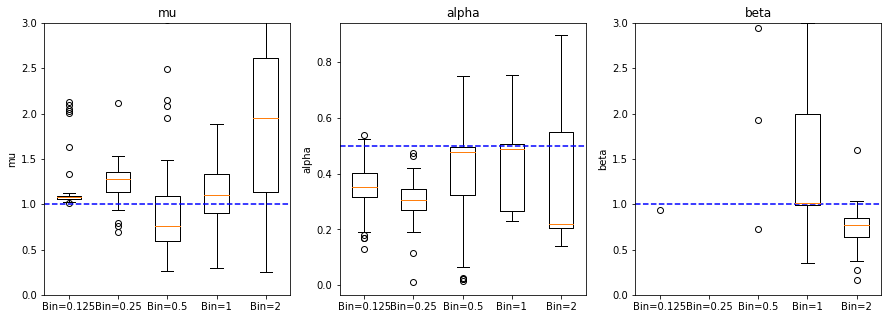

In [ ]:
# Graphing the results as 3 boxplots for each parameter. There should be as many boxplot graphs (containing 3 boxplots next to each other) for each binsize (0.25,0.5,1,2):

fig, ax = plt.subplots(1,3, figsize=(15,5))

# left subplot (mu)
ax1 = ax[0]
ax1.boxplot ([Results[0.125]['mu'],Results[0.25]['mu'],Results[0.5]['mu'],Results[1]['mu'],Results[2]['mu']])
ax1.set_xticklabels(['Bin=0.125','Bin=0.25','Bin=0.5','Bin=1','Bin=2'])
ax1.set_ylabel('mu')
ax1.set_title('mu')
#Add the true value to the plot (mu = 0.5)
ax1.axhline(1, color='blue', linestyle='--')
# Limit the y-axis to [0,3]
ax1.set_ylim(0,3)


# middle subplot (alpha)
ax2 = ax[1]
ax2.boxplot ([Results[0.125]['alpha'],Results[0.25]['alpha'],Results[0.5]['alpha'],Results[1]['alpha'],Results[2]['alpha']])
ax2.set_xticklabels(['Bin=0.125','Bin=0.25','Bin=0.5','Bin=1','Bin=2'])
ax2.set_ylabel('alpha')
ax2.set_title('alpha')
#Add the true value to the plot (alpha = 1)
ax2.axhline(0.5, color='blue', linestyle='--')

# right subplot (beta)
ax3 = ax[2]
ax3.boxplot ([Results[0.125]['beta'],Results[0.25]['beta'],Results[0.5]['beta'],Results[1]['beta'],Results[2]['beta']])
ax3.set_xticklabels(['Bin=0.125','Bin=0.25','Bin=0.5','Bin=1','Bin=2'])
ax3.set_ylabel('beta')
ax3.set_title('beta')
# Add the true value to the plot (beta = 1)
ax3.axhline(1, color='blue', linestyle='--')
# Limit the y-axis to [0,3]
ax3.set_ylim(0,3)

plt.show()

**Graph:**
Boxplot over 50 simulations for each binsize with T = 100. The true parameters are mu=1, alpha=0.5, beta=1. They correspond to the dashed blue line in the boxplots 

**Remark:** We clearly see how the precision degradates as the binsize increases for the three parameters. 

# Implementing the MLE in Python

In this section we implement the MLE in Python 

##Model class 

In [ ]:
class Model:
    def __init__(self, param):
        self.param = param

    def loglikngrad(self, events, end):
      n = len(events)
      eta = self.param[0]
      mu = self.param[1]
      beta = self.param[2]

      #Fill for i = 0
      lik = np.log(eta)
      #Iterate on arrival times 
      a, b, c, denom, expint = 0.0, 0.0, 0.0, 0.0, 0.0
      for i in range(1,n):
        expint = np.exp(-beta*(events[i]-events[i-1]))
        a = expint * (1.0+a)
        c = expint * (events[i-1]+c)
        b = events[i] * a - c
        denom = 1.0/(eta + mu * beta* a)
        lik+=np.log(eta+mu*beta*a)

      #Likelihood of non occurrence
      expint = np.exp(-beta*(end-events[n-1]))
      a = expint*(1.0+a)
      c=expint*(events[n-1]+c)
      b = end*a-c
      lik -= eta*end + mu*(float(n)-a)

      return -lik


##MLE function 

In [ ]:
def mle(events, end, init=None):
  
  
  def nlopt_fn(param):
    model = Model(param)
    return model.loglikngrad(events, end)

  def jacob(param):
    n = len(events)
    eta = param[0]
    mu = param[1]
    beta = param[2]

    #Fill for i = 0
    grad = np.array([1./eta, 0.0,0.0], dtype=float)
    #Iterate on arrival times 
    a, b, c, denom, expint = 0.0, 0.0, 0.0, 0.0, 0.0
    for i in range(1,n):
      expint = np.exp(-beta*(events[i]-events[i-1]))
      a = expint * (1.0+a)
      c = expint * (events[i-1]+c)
      b = events[i] * a - c
      denom = 1.0/(eta + mu * beta* a)
      grad[0]+= 1.0*denom
      grad[1]+=beta*a*denom
      grad[2]+=(mu*a-mu*beta*b)*denom

    #Likelihood of non occurrence
    expint = np.exp(-beta*(end-events[n-1]))
    a = expint*(1.0+a)
    c=expint*(events[n-1]+c)
    b = end*a-c
    grad[0]-=end
    grad[1]-= n-a
    grad[2] -= mu*b

    #on retourne un dico
    return -1*grad



  x0 = [np.random.uniform(0,2), np.random.uniform(0,1), np.random.uniform(0,2)]
  bnds = ((.0001, np.inf), (.0001, .9999), (.0001, np.inf))
  opt = so.minimize(nlopt_fn, x0,method="L-BFGS-B", bounds = bnds, jac=jacob) #enlever jac pour pour ne pas faire descente de gradient 
    
  return opt['x']


Test for one Hawkes process: 

In [ ]:
end = 2000
hawkes = proc_hawkes(1,0.5,1, end)
start_time = time()
x = mle(hawkes.timestamps[0], end)
end_time = time()

In [ ]:
print("--- %s seconds for MLE Estimation ---" % (end_time - start_time))
print ("mu=", x[0], ", alpha=", x[1], "et beta=", x[2])
print(x)


--- 1.277984380722046 seconds for MLE Estimation ---
mu= 1.0508129481251987 , alpha= 0.501027343563912 et beta= 0.8964104190806484
[1.05081295 0.50102734 0.89641042]


The MLE estimation is much faster than the Whittle estimation. Also, the estimation is very precise.

##Precision boxplots of the MLE estimation


In [ ]:
N = 100 # Number of simulations
T = [100,200,400,800,1600,3200]

mat_bxp_mle = np.zeros((6,3,N)) # len(T), param, simulations
estim = []
for j in range(len(T)):
  for i in range(N):
    hawkes = proc_hawkes(1,0.5,1,T[j])
    estim = mle(hawkes.timestamps[0], T[j])
    for k in range(3):
      mat_bxp_mle[j,k,i]=estim[k]



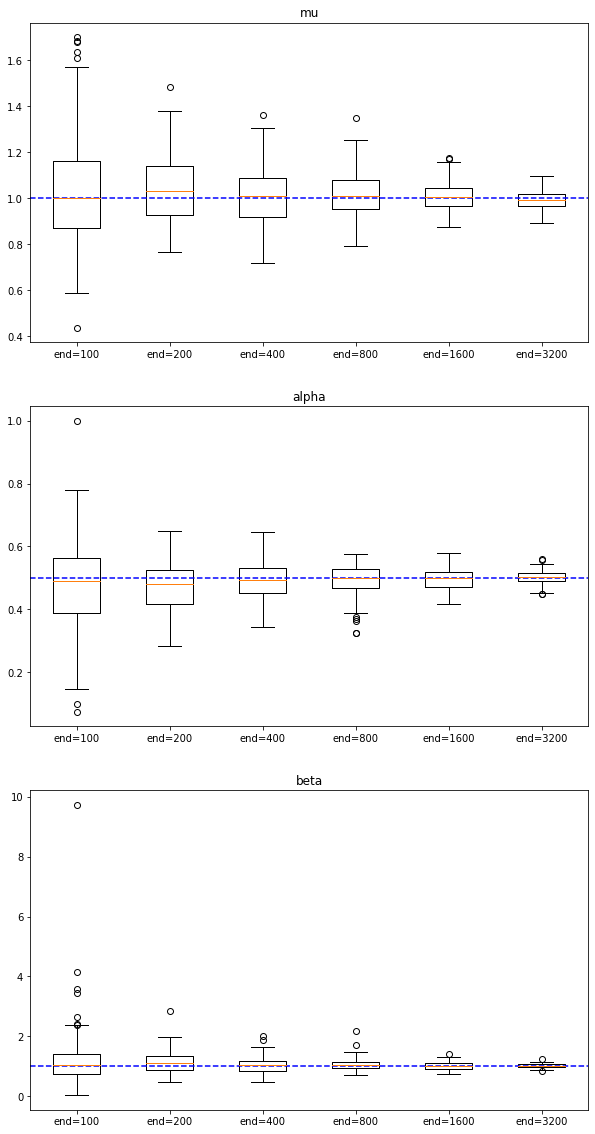

In [ ]:
#Boxplot en fonction de end 

fig, ax = plt.subplots(3,figsize=(10,20))

ax[0].boxplot([mat_bxp_mle[0,0,:], mat_bxp_mle[1,0,:], mat_bxp_mle[2,0,:], mat_bxp_mle[3,0,:], mat_bxp_mle[4,0,:], mat_bxp_mle[5,0,:]])
ax[0].set_xticklabels(['end=100','end=200','end=400','end=800','end=1600', 'end=3200'])
ax[0].set_title('mu')
ax[0].axhline(1, color='blue', linestyle='--')


ax[1].boxplot([mat_bxp_mle[0,1,:], mat_bxp_mle[1,1,:], mat_bxp_mle[2,1,:], mat_bxp_mle[3,1,:], mat_bxp_mle[4,1,:], mat_bxp_mle[5,1,:]])
ax[1].set_xticklabels(['end=100','end=200','end=400','end=800','end=1600', 'end=3200'])
ax[1].set_title('alpha')
ax[1].axhline(0.5, color='blue', linestyle='--')



ax[2].boxplot([mat_bxp_mle[0,2,:], mat_bxp_mle[1,2,:], mat_bxp_mle[2,2,:], mat_bxp_mle[3,2,:], mat_bxp_mle[4,2,:], mat_bxp_mle[5,2,:]])
ax[2].set_xticklabels(['end=100','end=200','end=400','end=800','end=1600', 'end=3200'])
ax[2].set_title('beta')
ax[2].axhline(1, color='blue', linestyle='--')

plt.show()
    


**Graph:**
Boxplots over 100 simulations depending on time horizon T.

**Remark:** The bigger the Hawkes process, the better the estimation becomes. Note that the MLE doesn't take in entry a binsize like the Whittle estimation. 

## Execution time comparison

In [ ]:
T = [100,200,400,800,1600,3200]
time_list = []
for end in T:
  start_time = time()
  for j in range(10):
    hawkes = proc_hawkes(1,0.5,1, end)
    mle(hawkes.timestamps[0], end)
  end_time=  time()
  time_list.append(end_time-start_time)


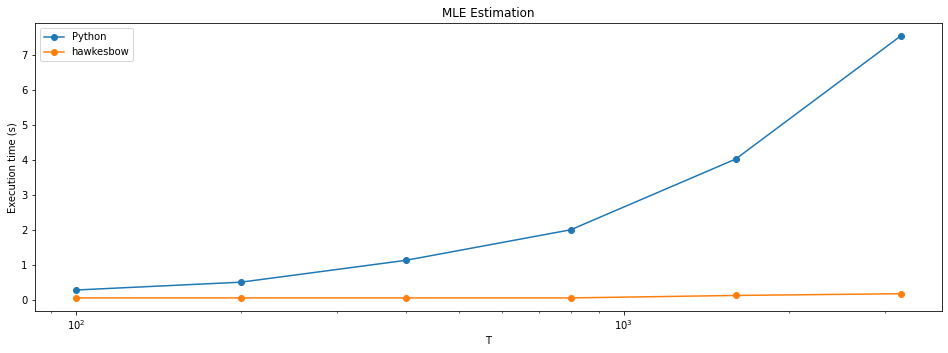

In [ ]:
time_list_r = [0.06,0.06,0.06,0.06,0.13,0.18]

fig1 = plt.figure(figsize=(18,5))
ax = fig1.add_axes([0.1, 0.1, 0.7, 0.8])
ax.plot(T, time_list, label="Python", marker='o')
ax.plot(T, time_list_r, label='hawkesbow', marker='o')
ax.set_title("MLE Estimation")
ax.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('Execution time (s)')
plt.show()

**Graph:**

x-axis: end time T of the Hawkes process 

y-axis: time to execute 10 MLE estimations

**Remark:** 
Once again, the R code is much quicker. Up to 42 times faster for T = 3200. Moreover, it is interesting to note that in the R implementation, the estimation seems totally indepedent of time horizon T !

# Randomization impact on Whittle estimation method

**Remark:** In this section we simply expose the code used to plot the graphs of our paper. For futher details see section 3.3 of our paper.

In [ ]:
def randomization(y, binsize):
  time = []
  t = 0
  L = len(y)
  for i in range(L):
    if y[i] == 0:
      pass
    else:
      for j in range(1, y[i]+1):
        time.append(t+j*binsize/(y[i]+1))
    t += binsize
  return np.array(time)


def proc_hawkes(mu, alpha, beta, end):
  baseline = np.array([mu])
  hawkes = SimuHawkes(baseline=baseline, end_time=end)
  hawkes.set_kernel(0, 0, HawkesKernelExp(alpha, beta))
  hawkes.simulate()
  return hawkes

N=50
end=500
bins=np.linspace(0.1,0.6,12)
w,m=[],[]
for bin in bins:
  
  sw=np.array([0,0,0])
  sm=np.array([0,0,0])
  for i in range(N):
    hawkes = proc_hawkes(1,0.8,1,end)
    y = discrete(hawkes.timestamps, hawkes.end_time, binsize = bin) 
    whi=whittle(y,binsize=bin,trunc=5)
    ml=mle(randomization(y,bin), end)
    sw=sw+np.abs(np.array([1,0.8,1])-whi)
    sm=sm+np.abs(np.array([1,0.8,1])-ml)
  m.append(1/N*sm)
  w.append(1/N*sw)

muw,alphaw,betaw=[],[],[]
mum,alpham,betam=[],[],[]
for i in range(len(w)):
  muw.append(w[i][0])
  alphaw.append(w[i][1])
  betaw.append(w[i][2])
  mum.append(m[i][0])
  alpham.append(m[i][1])
  betam.append(m[i][2])
  

# Alpha simulation

plt.xlabel('binsize')
plt.ylabel('alpha mean error')
plt.legend()
plt.title('Robustesse face à la dégradation des données')
plt.plot(bins,alphaw,'r', label='whittle')
plt.plot(bins,alpham, 'b', label='mle')
plt.legend()
plt.yscale('log')
plt.show()
# Beta simulation
plt.xlabel('binsize')
plt.ylabel('beta mean error')
plt.legend()
plt.title('Robustesse face à la dégradation des données')
plt.plot(bins,betaw,'g', label='whittle')
plt.plot(bins,betam, 'b', label='mle')
plt.legend()
plt.yscale('log')
plt.show()

# mu simulation

plt.xlabel('binsize')
plt.ylabel(' mu mean error')
plt.legend()
plt.title('Robustesse face à la dégradation des données')
plt.plot(bins,muw,'y', label='whittle')
plt.plot(bins,mum, 'b', label='mle')
plt.legend()
plt.yscale('log')
plt.show()

# Powerlaw 

In all this section, the kernel is no longer exponential but powerlaw. We know that the computational complexity for the Whittle estimation is linear for exponential kernels but becomes quadratic otherwise. This is what we try to show numerically in this section.

##Intensity with a powerlaw kernel

----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.52e+00 seconds.


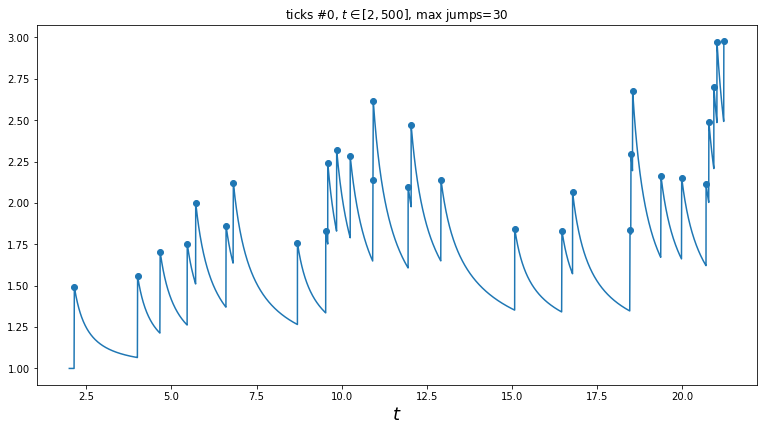

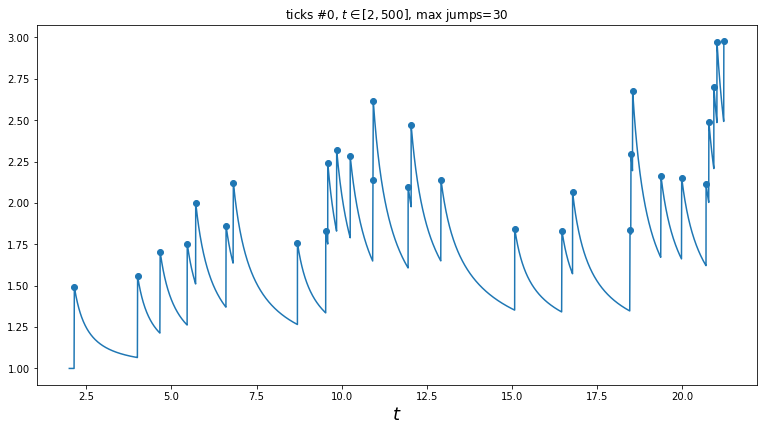

In [ ]:
baseline = np.array([1])
hawkes = SimuHawkes(baseline=baseline, end_time=500)
hawkes.set_kernel(0, 0, HawkesKernelPowerLaw(0.2, 0.5, 1.3))


dt = 0.01
hawkes.track_intensity(dt)
hawkes.simulate()

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
plot_point_process(hawkes, n_points=50000, t_min=2, max_jumps=30, ax=ax)



**Remark:** Powerlaw and exponentiel kernels seem quite similar. However, several studies show that powerlaw kernels fit better financial data.

##Generate a Hawkes process with Powerlaw

In [ ]:
def gen_hawkes_pl(baseline , multiplier, cutoff, exponent, end):
  baseline = np.array([baseline])
  hawkes = SimuHawkes(baseline=baseline, end_time=end)
  hawkes.set_kernel(0, 0, HawkesKernelPowerLaw(multiplier, cutoff, exponent))
  hawkes.simulate()
  return hawkes

## Execution time on R 

Our Python code to estimate Hawkes processes with powerlaw kernels isn't operational yet (see the code we have at the moment going from the "Powerlaw computations" sub-section). Yet, we found it very interesting to compare time executions compared to exponential kernels with the hawkesbow library in R. This is what we found:    

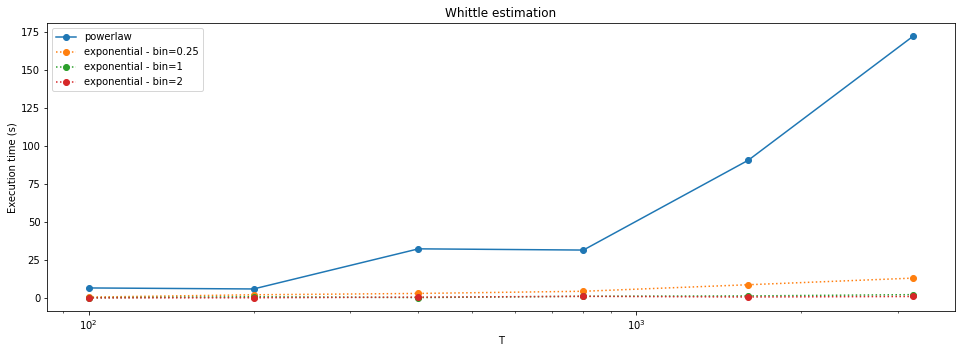

In [ ]:
l = [6.36, 21.64, 30.47, 44.83, 87.82, 131.48]
l_1 = [2.58, 8.74, 3.36, 11.80, 14.25, 22.62]
l_2 = [1.11, 2.22, 6.06, 11.40, 7.21, 10.48]
l = np.array(l)
l = l/10
l_1 = np.array(l_1)
l_1 = l_1/10
l_2 = np.array(l_2)
l_2=l_2/10

#list of execution times with R
time_list_r = [6.67, 6, 32.41, 31.61, 90.76, 172.45]

T = [100,200,400,800,1600,3200]
fig1 = plt.figure(figsize=(18,5))
ax = fig1.add_axes([0.1, 0.1, 0.7, 0.8])
ax.plot(T, time_list_r, label='powerlaw', marker='o')
ax.plot(T, l, label='exponential - bin=0.25', marker='o', ls=':')
ax.plot(T, l_1, label='exponential - bin=1', marker='o', ls=':')
ax.plot(T, l_2, label='exponential - bin=2', marker='o', ls=':')
ax.set_title("Whittle estimation")
ax.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('Execution time (s)')
plt.show()


**Graph:** 

x-axis: end time of the Hawkes process 

y-axis: time execution to estimate 100 Hawkes processes  




**Remark:**
This graph confirms the particularly long time execution needed to estimate powerlaw kernels. The computation is 172 times longer for T = 3200 and bin = 2. 

## Powerlaw computations

This section needs debugging to run Whittle estimation on Python. Fix it will be one of our future objectives

Given that the process isn't a Markov process anymore, the computations are much heavier and the code is longer:

In [ ]:
def pow_i(x):
  rem = x % 4
  if rem == 1:
      return 1j
  elif rem == 2:
      return -1
  elif rem == 3:
      return -1j
  elif rem == 0:
      return 1
  else:
      return 0

def pow_m1(x):
  rem = x % 2
  if rem == 1:
      return -1
  elif rem == 0:
      return 1
  return 0

def quick_pow10(n):
    pow10 = [
        1.0, 10.0, 100.0, 1000.0, 10000.0,
        100000.0, 1000000.0, 10000000.0, 100000000.0, 1000000000.0,
        10000000000.0, 100000000000.0, 1000000000000.0, 10000000000000.0
    ]

    return pow10[n]

def quick_negpow10(n):
    pow10 = [
        1.0, 0.1, 0.01, 0.001, 0.0001,
        0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001,
        0.0000000001, 0.00000000001, 0.000000000001, 0.0000000000001, 0.00000000000001,
        0.000000000000001, 0.0000000000000001, 0.00000000000000001, 0.000000000000000001
    ]

    return pow10[n]


def padef(x):
    inv_x = 1.0 / x
    inv_x2 = inv_x * inv_x

    num = 1 + inv_x2 * (7.44437068161936700618 * quick_pow10(2) + inv_x2 * (1.96396372895146869801 * quick_pow10(5) + inv_x2 * (2.37750310125431834034 * quick_pow10(7) + inv_x2 * (1.43073403821274636888 * quick_pow10(9) + inv_x2 * (4.33736238870432522765 * quick_pow10(10) + inv_x2 * (6.40533830574022022911 * quick_pow10(11) + inv_x2 * (4.20968180571076940208 * quick_pow10(12) + inv_x2 * (1.00795182980368574617 * quick_pow10(13) + inv_x2 * (4.94816688199951963482 * quick_pow10(12) + inv_x2 * (- 4.94701168645415959931 * quick_pow10(11)))))))))))
    
    denom = 1 + inv_x2 * (7.46437068161927678031 * quick_pow10(2)  + inv_x2 * (1.97865247031583951450 * quick_pow10(5) + inv_x2 * (2.41535670165126845144 * quick_pow10(7) + inv_x2 * (1.47478952192985464958 * quick_pow10(9) + inv_x2 * (4.58595115847765779830 * quick_pow10(10) + inv_x2 * (7.08501308149515401563 * quick_pow10(11) + inv_x2 * (5.06084464593475076774 * quick_pow10(12) + inv_x2 * (1.43468549171581016479 * quick_pow10(13) + inv_x2 * (1.11535493509914254097 * quick_pow10(13))))))))))

    return inv_x * num / denom




def padeg(x):
    inv_x = 1.0 / x
    inv_x2 = inv_x * inv_x

    num = 1 + \
        inv_x2 * (8.1359520115168615 * 10**2 + \
        inv_x2 * (2.35239181626478200 * 10**5 + \
        inv_x2 * (3.12557570795778731 * 10**7 + \
        inv_x2 * (2.06297595146763354 * 10**9 + \
        inv_x2 * (6.83052205423625007 * 10**10 + \
        inv_x2 * (1.09049528450362786 * 10**12 + \
        inv_x2 * (7.57664583257834349 * 10**12 + \
        inv_x2 * (1.81004487464664575 * 10**13 + \
        inv_x2 * (6.43291613143049485 * 10**12 + \
        inv_x2 * (- 1.36517137670871689 * 10**12))))))))))

    denom = 1 + \
        inv_x2 * (8.19595201151451564 * 10**2 + \
        inv_x2 * (2.40036752835578777 * 10**5 + \
        inv_x2 * (3.26026661647090822 * 10**7 + \
        inv_x2 * (2.23355543278099360 * 10**9 + \
        inv_x2 * (7.87465017341829930 * 10**10 + \
        inv_x2 * (1.39866710696414565 * 10**12 + \
        inv_x2 * (1.17164723371736605 * 10**13 + \
        inv_x2 * (4.01839087307656620 * 10**13 + \
        inv_x2 * (3.99653257887490811 * 10**13)))))))))

    return inv_x2 * num / denom



def Ci(x):
    
    if x < 0:
        raise ValueError("ERROR in Ci: 'x' cannot be negative.")
    
    if x <= 4:
        x2 = x*x
        
        num = -0.25 + \
            x2*(7.51851524438898291*quick_negpow10(3) + \
            x2*(-1.27528342240267686*quick_negpow10(4) + \
            x2*(1.05297363846239184*quick_negpow10(6) + \
            x2*(-4.68889508144848019*quick_negpow10(9) + \
            x2*(1.06480802891189243*quick_negpow10(11) + \
            x2*(-9.93728488857585407*quick_negpow10(15)))))))
        
        denom = 1 + \
            x2*(1.1592605689110735*quick_negpow10(2) + \
            x2*(6.72126800814254432*quick_negpow10(5) + \
            x2*(2.55533277086129636*quick_negpow10(7) + \
            x2*(6.97071295760958946*quick_negpow10(10) + \
            x2*(1.38536352772778619*quick_negpow10(12) + \
            x2*(1.89106054713059759*quick_negpow10(15) + \
            x2*(1.39759616731376855*quick_negpow10(18))))))))
        
        return math.e + math.log(x) + x2*num/denom
    
    return padef(x)*math.sin(x) - padeg(x)*math.cos(x)




def Si(x):
    if x < 0:
        raise ValueError("ERROR in Si: 'x' cannot be negative.")
    if x <= 4:
        x2 = x * x
        num = 1 + x2 * (- 4.54393409816329991 * quick_negpow10(2) + x2 * (1.15457225751016682 * quick_negpow10(3) + x2 * (- 1.41018536821330254 * quick_negpow10(5) + x2 * (9.43280809438713025 * quick_negpow10(8) + x2 * (- 3.53201978997168357 * quick_negpow10(10) + x2 * (7.08240282274875911 * quick_negpow10(13) + x2 * (- 6.05338212010422477 * quick_negpow10(16))))))))
        denom = 1 + x2 * (1.01162145739225565 * quick_negpow10(2) + x2 * (4.99175116169755106 * quick_negpow10(5) + x2 * (1.55654986308745614 * quick_negpow10(7) + x2 * (3.28067571055789734 * quick_negpow10(10) + x2 * (4.5049097575386581 * quick_negpow10(13) + x2 * (3.21107051193712168 * quick_negpow10(16)))))))
        return x * num / denom
    return 0.5 * np.pi - padef(x) * np.cos(x) - padeg(x) * np.sin(x)



def E1_imaginary(x):

    if x < 0:
        raise ValueError("ERROR in E1_imaginary: 'x' cannot be negative.")

    return 1j * (- 0.5 * np.pi + Si(x)) - Ci(x)




def inc_gamma_imag( x, alpha ):
    
    if x < 0.0:
        raise ValueError("ERROR in inc_gamma_imag: 'x' cannot be negative.")
    
    if x == 0.0:
        return np.exp(-0.5*np.pi*alpha*1j) * math.gamma(alpha)
    
    if alpha <= 0.0 or alpha >= 1.0:
        raise ValueError("ERROR in inc_gamma_imag: 'alpha' must be between 0 and 1 strictly.")
      
    if x < 20.0:
        n = int(np.ceil(7.0 + 1.36 * x))  # Change constant term 'a' to get an approximation to order 10^{-a-1}
        x2 = x * x
        xalpha = np.exp(alpha * np.log(x))

        evens = 2 * np.arange(1, n+1)
        oddsm1 = 2 * np.arange(1, n+1) - 1
        oddsp1 = 2 * np.arange(1, n+1) + 1
        Ci_summands = np.cumprod(-x2 / (evens * oddsm1)) / (evens + alpha)
        Si_summands = np.cumprod(-x2 / (evens * oddsp1)) / (oddsp1 + alpha)

        Ci = xalpha * (1.0 / alpha + np.sum(Ci_summands))
        Si = x * xalpha * (1.0 / (1.0 + alpha) + np.sum(Si_summands))

        return np.exp(1j*(-.5)*np.pi*alpha) * math.gamma(alpha) - Ci + 1j*Si

    # Taylor expansion of f and g around x -> infty, only 10 terms calculated
    # This approximation is at most of order 10^{-8}
    # Can't be used for x < 20 because then it is of lower order
    n = 10
    inv_x = 1.0 / x
    inv_x2 = inv_x * inv_x
    xalpha = np.exp(alpha * np.log(x))

    evens = alpha - 2.0 * np.arange(1, n+1)
    oddsf = alpha - 2.0 * np.arange(1, n+1) + 1.0
    oddsg = alpha - 2.0 * np.arange(1, n) - 1.0
    summands_f = np.cumprod(- inv_x2 * evens * oddsf)
    summands_g = np.cumprod(- inv_x2 * evens[0:n-1] * oddsg)

    taylorf = (xalpha * inv_x) * (1.0 + np.sum(summands_f))
    taylorg = (1.0 - alpha) * (xalpha * inv_x2) * (1.0 + np.sum(summands_g))

    Ci = taylorg * np.cos(x) - taylorf * np.sin(x)
    Si = taylorg * np.sin(x) + taylorf * np.cos(x)

    return Ci - 1j*Si



def Etheta_imaginary(theta, x):
      y = np.zeros(x.shape, dtype=float)
      print(y)

      if np.fmod(theta, 1.0) == 0.0: # Tests if theta is integer
        itheta = int(np.floor(theta))

        if itheta == 1:
          # Loop on x
          for i in range(x.shape[0]):
            y[i] = 1j *(-1)* x[i] * np.exp(1j * x[i]) * E1_imaginary(x[i])
        else:
          # Term 1 with sum from k = 1 up to theta - 1
          xiprod = np.cumprod(np.kron(np.ones((itheta - 1, 1)), x), 1)
          summands_den = np.cumprod(theta - np.arange(1, itheta, 1))
          summands_num = np.cumprod(1j *(-1)* np.ones((itheta - 1, 1)))
          term1 = xiprod*(summands_num / summands_den)
          print(xiprod.shape)

          # Get last elements that appear in the sum
          last_xiprod = xiprod[:, itheta - 2]
          last_num = summands_num[-1]
          last_den = summands_den[-1]

          # Term 2 with exponential integral
          term2 = np.zeros(x.shape, dtype=np.complex)
          term2 = -1*1j * x * last_num * last_xiprod * np.exp(1*1j * x) * E1_imaginary(x) / last_den #vectoriser la fonction E1 si ca marche pas 

          y = term1 + term2

      else:  #theta is not integer 
        itheta = int(np.floor(theta))

        if itheta==0:
          y = -1*1j * x * np.exp(1*1j*x) * np.exp((theta-1.0)*np.log(x)) * inc_gamma_imag(x, 1.0-theta) #penser a vectoriser...
        else:
          # Term 1 with sum from k = 1 up to itheta
          xiprod = np.cumprod(np.kron(np.ones((itheta, 1)), x), 1)
          summands_den = np.cumprod(theta - np.arange(1, itheta+1))
          summands_num = np.cumprod(-1*1j * np.ones(itheta))
          term1 = xiprod * (summands_num / summands_den)
          # Get last elements that appear in the denominator
          last_den = summands_den[-1]

          # Term 2 with exponential integral
          term2 = np.zeros(x.shape, dtype=np.complex)
          term2 = pow_m1(itheta+1) * pow_i(itheta+1) * np.exp(1j*x) * np.exp(theta*np.log(x)) * inc_gamma_imag(x, 1-theta+itheta) / last_den # vectoriser la fonction 

          y = term1 + term2
      return y




## Powerlaw class

In [ ]:
class Powerlaw:
    def __init__(self, param, binsize):
        self.param = param
        self.binsize = binsize

    def mean(self):
      return (self.param[0] / (1.0 - self.param[1]))

    
  
    def H(xi, param):
      mu = param[1]
      theta = param[2]
      a = param[3]
      xia = a * np.abs(xi)

      y = mu * (1 + Etheta_imaginary(theta, xia))

      # Iterators
      it_xi = xi[0]
      it_xi_end = xi[-1]
      it_y = y[0]

      # For xi < 0, take the conjugate
      for it_xi, it_y in zip(it_xi, it_y):
          if it_xi == 0.0:
              it_y = mu
          elif it_xi < 0.0:
              it_y = np.conj(it_y)

      return y




    
    #G(w) = |1-H(w)|^{-2}
    def G(self, xi):
      return 1.0 / ( (1.0 - Exponential.H(self, xi)) * (1.0 - np.conj(Exponential.H(self, xi))) )

    #f(w) = m * binsize * sinc²(w/2) * G(w/binsize)

    def f(self, xi):
        term1 = sinc(.5 * xi)
        return Exponential.mean(self) * self.binsize * term1 * term1 * Exponential.G(self,  xi / self.binsize )
    
    #f1(w) = sum_{k=-trunc}^{+trunc} f(w + 2*k*pi)

    def f1(self, xi, trunc):
      omega = 2 * np.pi * np.arange(-trunc, trunc+1)
      y = np.zeros(xi.shape)
      for k in range(xi.shape[0]):
        y[k] = np.sum(Exponential.f(self, xi[k] + omega))
      return y
    
    def whittle(self, periodogram, trunc,console_show=False):
      n = len(periodogram) + 1
      n2 = n // 2
      omega = 2.0 * np.pi * np.arange(1, n2 + 1) / float(n)
      spectrum = Exponential.f1(self, omega, trunc)
      if console_show:
        print(spectrum)
      return np.sum(np.log(spectrum) + periodogram[0:n2] / spectrum)
    

##The Whittle estimation 


In [ ]:
def whittle_pl(counts, binsize, trunc = 5):
  #Periodogram
  N = len(counts)
  dft = np.fft.fft(counts - np.mean(counts))
  I = np.abs(dft)**2 / N
  I = I[1:]

  def nlopt_fn(param):
        expo = Exponential(param, binsize)
        return expo.whittle(I, trunc)

  ymean = np.mean(counts)
  param = np.array([0.0,0.0,0.0, 0.0],dtype='float')
  wmin = np.inf
  mu = 0.25
  shape = 1
  scale = 1
  for mu_ in [0.25,0.5,0.75]:
    for shape_ in np.arange(0.5,5.5,0.5):
      for scale_ in np.arange(0.5,5.5,0.5):
        param[0] = ymean * (1-mu_)
        param[1] = mu_
        param[2] = shape_
        param[3] = scale_
        whit = Exponential.whittle(I, trunc)
        if whit <wmin:
          mu = mu_
          shape = shape_
          scale = scale_
          wmin = whit
  x0 = [ymean * (1-mu), mu, shape, scale]
  bnds = ((0.01, np.inf), (0.01, 0.99), (0.01, np.inf), (0.01, np.inf))
  opt = so.minimize(nlopt_fn, x0,method="L-BFGS-B", bounds = bnds)
    
  return opt['x']




# Annex

In this section we attempted to perform Whittle estimation on a new process: Hawkes + Epsilon where Epsilon is a uniform distribution which adds a certain percentage of noise to the timestamps series. However, this transformation doesn't seem the most relevant because it distorts the nature of the Hawkes process Nevertheless we put the code here if it turns out it can be useful in some way.  

In [ ]:
def hawkes_noise(Percentage_of_noise,mu=1, alpha=0.5, beta=1, end = 1000,binsize=0.5):
        
    hawkes = proc_hawkes(mu,alpha,beta, end)
    new_timestamps = np.array(hawkes.timestamps) 
    # Let's add x% of noise to the timestamps (uniform distribution from 0 to hawkes.end_time)
    number_of_noise_points= int(len(hawkes.timestamps[0]) * Percentage_of_noise)
    noise = np.random.uniform(0, hawkes.end_time, number_of_noise_points)

    for point in noise:
        # add point to new_timestamps
        new_timestamps = np.append(new_timestamps, point)
    # Let's sort the timestamps
    new_timestamps= [np.sort(new_timestamps)]

    y = discrete(hawkes.timestamps, hawkes.end_time, binsize)
    new_y = discrete(new_timestamps, hawkes.end_time, binsize)
    
    return y,new_y, hawkes.timestamps, new_timestamps

In [ ]:
# Test: to be removed
mu,alpha,beta = (1,0.5,1)
binsize = 0.5
y,new_y, original_timestamps, noisy_timestamps = hawkes_noise(0.5, mu,alpha,beta,end,binsize)
end = 200
estim_original_mle = mle(original_timestamps[0], end)
print(estim_original_mle)
estim_noisy_mle = mle(noisy_timestamps[0], end)
print(estim_noisy_mle)

x = whittle(y, binsize)
print(x)
x1 = whittle(new_y,binsize)
print(x1)

#plot original timestamps and noisy timestamps
figure1 = plt.figure(figsize=(20,10))
plt.hist(noisy_timestamps, bins=200, label='noisy timestamps')
plt.hist(original_timestamps, bins=200, label='original timestamps')
plt.legend(loc='upper right')
plt.show()
# plot the original and the noisy data
figure = plt.figure(figsize=(12,8))
plt.hist(y, bins=np.arange(0, y.max()+1, 0.5), alpha=0.5, label='original')
plt.hist(new_y, bins=np.arange(0, y.max()+1, 0.5), alpha=0.5, label='noisy')
plt.legend()
plt.show()

In [ ]:
# Let's do some simulations with different noise levels (100 from 1% to 20%) and measure the whittle parameters (mu, alpha, beta)
Estimation_results_mu = {'mle_original': [], 'mle_noisy': [], 'whittle_original': [], 'whittle_noisy': []}
Estimation_results_alpha = {'mle_original': [], 'mle_noisy': [], 'whittle_original': [], 'whittle_noisy': []}
Estimation_results_beta = {'mle_original': [], 'mle_noisy': [], 'whittle_original': [], 'whittle_noisy': []}

mu,alpha,beta = (1,0.5,1)
binsize = 0.5
end = 200 # Temps de fin
N= 5 # Number of simulations

max_noise = 40 # Max noise level

for i in range(1,max_noise+1):
    Results_mu = {'mle_original': [], 'mle_noisy': [], 'whittle_original': [], 'whittle_noisy': []}
    Results_alpha = {'mle_original': [], 'mle_noisy': [], 'whittle_original': [], 'whittle_noisy': []}
    Results_beta = {'mle_original': [], 'mle_noisy': [], 'whittle_original': [], 'whittle_noisy': []}

    for j in range(N): # N simulations to get an average
        y,new_y, original_timestamps, noisy_timestamps = hawkes_noise(i/100, mu,alpha,beta,end,binsize)
        
        # Let's estimate the parameters
        
        estim_original_mle = mle(original_timestamps[0], end)
        Results_mu['mle_original'].append(estim_original_mle[0])
        Results_alpha['mle_original'].append(estim_original_mle[1])
        Results_beta['mle_original'].append(estim_original_mle[2])


        estim_noisy_mle = mle(noisy_timestamps[0], end)
        Results_mu['mle_noisy'].append(estim_noisy_mle[0])
        Results_alpha['mle_noisy'].append(estim_noisy_mle[1])
        Results_beta['mle_noisy'].append(estim_noisy_mle[2])

        estim_original_whittle = whittle(y, binsize)
        Results_mu['whittle_original'].append(estim_original_whittle[0])
        Results_alpha['whittle_original'].append(estim_original_whittle[1])
        Results_beta['whittle_original'].append(estim_original_whittle[2])

        estim_noisy_whittle = whittle(new_y, binsize)
        Results_mu['whittle_noisy'].append(estim_noisy_whittle[0])
        Results_alpha['whittle_noisy'].append(estim_noisy_whittle[1])
        Results_beta['whittle_noisy'].append(estim_noisy_whittle[2])
        
    # Let's get the average of the N simulations
    Estimation_results_mu['mle_original'].append(np.mean(Results_mu['mle_original'])) 
    Estimation_results_mu['mle_noisy'].append(np.mean(Results_mu['mle_noisy']))
    Estimation_results_mu['whittle_original'].append(np.mean(Results_mu['whittle_original']))
    Estimation_results_mu['whittle_noisy'].append(np.mean(Results_mu['whittle_noisy']))
    Estimation_results_alpha['mle_original'].append(np.mean(Results_alpha['mle_original']))
    Estimation_results_alpha['mle_noisy'].append(np.mean(Results_alpha['mle_noisy']))
    Estimation_results_alpha['whittle_original'].append(np.mean(Results_alpha['whittle_original']))
    Estimation_results_alpha['whittle_noisy'].append(np.mean(Results_alpha['whittle_noisy']))
    Estimation_results_beta['mle_original'].append(np.mean(Results_beta['mle_original']))
    Estimation_results_beta['mle_noisy'].append(np.mean(Results_beta['mle_noisy']))
    Estimation_results_beta['whittle_original'].append(np.mean(Results_beta['whittle_original']))
    Estimation_results_beta['whittle_noisy'].append(np.mean(Results_beta['whittle_noisy']))
    print(i/max_noise)
        



In [ ]:
# Let's plot the results
figure2 = plt.figure(figsize=(20,10))
plt.plot(np.arange(1,max_noise+1)/max_noise, Estimation_results_mu['mle_original'], label='mle_original')
plt.plot(np.arange(1,max_noise+1)/max_noise, Estimation_results_mu['mle_noisy'], label='mle_noisy')
plt.plot(np.arange(1,max_noise+1)/max_noise, Estimation_results_mu['whittle_original'], label='whittle_original')
plt.plot(np.arange(1,max_noise+1)/max_noise, Estimation_results_mu['whittle_noisy'], label='whittle_noisy')
# Plot true mu
plt.plot(np.arange(1,max_noise+1)/max_noise, np.ones(max_noise)*mu, label='true mu')
plt.legend()
plt.title('Estimation of mu')
plt.xlabel('Noise level')
plt.ylabel('mu')
plt.show()
figure3 = plt.figure(figsize=(20,10))
plt.plot(np.arange(1,max_noise+1)/max_noise, Estimation_results_alpha['mle_original'], label='mle_original')
plt.plot(np.arange(1,max_noise+1)/max_noise, Estimation_results_alpha['mle_noisy'], label='mle_noisy')
plt.plot(np.arange(1,max_noise+1)/max_noise, Estimation_results_alpha['whittle_original'], label='whittle_original')
plt.plot(np.arange(1,max_noise+1)/max_noise, Estimation_results_alpha['whittle_noisy'], label='whittle_noisy')
# Plot true alpha
plt.plot(np.arange(1,max_noise+1)/max_noise, np.ones(max_noise)*alpha, label='true alpha')
plt.legend()
plt.title('Estimation of alpha')
plt.xlabel('Noise level')
plt.ylabel('alpha')
plt.show()
figure4 = plt.figure(figsize=(20,10))
plt.plot(np.arange(1,max_noise+1)/max_noise, Estimation_results_beta['mle_original'], label='mle_original')
plt.plot(np.arange(1,max_noise+1)/max_noise, Estimation_results_beta['mle_noisy'], label='mle_noisy')
plt.plot(np.arange(1,max_noise+1)/max_noise, Estimation_results_beta['whittle_original'], label='whittle_original')
plt.plot(np.arange(1,max_noise+1)/max_noise, Estimation_results_beta['whittle_noisy'], label='whittle_noisy')
# Plot true beta
plt.plot(np.arange(1,max_noise+1)/max_noise, np.ones(max_noise)*beta, label='true beta')
plt.legend()
plt.title('Estimation of beta')
plt.xlabel('Noise level')
plt.ylabel('beta')
plt.show()

In [ ]:
binsize = 0.2
end = 1000 # Temps de fin

Results_mu_2 = {'mle_original': [], 'mle_noisy': [], 'whittle_original': [], 'whittle_noisy': []}
Results_alpha_2 = {'mle_original': [], 'mle_noisy': [], 'whittle_original': [], 'whittle_noisy': []}
Results_beta_2 = {'mle_original': [], 'mle_noisy': [], 'whittle_original': [], 'whittle_noisy': []}

hawkes = proc_hawkes(1,0.5,1, end)

# add 1% noise to the data each time from 0 to 100% noise

y = discrete(hawkes.timestamps, hawkes.end_time, binsize)
estim_original_whittle = whittle(y, binsize)
Results_mu_2['whittle_original'].append(estim_original_whittle[0])
Results_alpha_2['whittle_original'].append(estim_original_whittle[1])
Results_beta_2['whittle_original'].append(estim_original_whittle[2])

estim_original_mle = mle(hawkes.timestamps[0], hawkes.end_time)
Results_mu_2['mle_original'].append(estim_original_mle[0])
Results_alpha_2['mle_original'].append(estim_original_mle[1])
Results_beta_2['mle_original'].append(estim_original_mle[2])

print('Original MLE')
print(estim_original_mle)
print('Original Whittle')
print(estim_original_whittle)

new_timestamps = np.array(hawkes.timestamps) 

for j in range(1,51):
    # add 1% noise
    new_timestamps = np.append(new_timestamps, np.random.uniform(0,end,int(len(hawkes.timestamps[0])*0.01)))

    # Let's sort the timestamps
    new_timestamps = [np.sort(new_timestamps)]

    new_y = discrete(new_timestamps, hawkes.end_time, binsize)
    
    estim_noisy_mle = mle(new_timestamps[0], hawkes.end_time)
    Results_mu_2['mle_noisy'].append(estim_noisy_mle[0])
    Results_alpha_2['mle_noisy'].append(estim_noisy_mle[1])
    Results_beta_2['mle_noisy'].append(estim_noisy_mle[2])

    estim_noisy_whittle = whittle(new_y, binsize)
    Results_mu_2['whittle_noisy'].append(estim_noisy_whittle[0])
    Results_alpha_2['whittle_noisy'].append(estim_noisy_whittle[1])
    Results_beta_2['whittle_noisy'].append(estim_noisy_whittle[2])

    print('--------------- Estimation trial ' + str(j) + ' of 100 ---------------')


In [ ]:
# Plot the results
figure5 = plt.figure(figsize=(20,10)) 
# mle noisy
plt.plot(np.arange(1,len(Results_mu_2['mle_noisy'])+1), Results_mu_2['mle_noisy'], label='mle_noisy') 
# whittle noisy
plt.plot(np.arange(1,len(Results_mu_2['whittle_noisy'])+1), Results_mu_2['whittle_noisy'], label='whittle_noisy')
plt.xlabel('Noise level')
plt.ylabel('mu')
plt.legend()
plt.title('Estimation of mu')
plt.show()

figure6 = plt.figure(figsize=(20,10))
# mle noisy
plt.plot(np.arange(1,len(Results_alpha_2['mle_noisy'])+1), Results_alpha_2['mle_noisy'], label='mle_noisy')
# whittle noisy
plt.plot(np.arange(1,len(Results_alpha_2['whittle_noisy'])+1), Results_alpha_2['whittle_noisy'], label='whittle_noisy')
plt.xlabel('Noise level')
plt.ylabel('alpha')
plt.legend()
plt.title('Estimation of alpha')
plt.show()

figure7 = plt.figure(figsize=(20,10))
# mle noisy
plt.plot(np.arange(1,len(Results_beta_2['mle_noisy'])+1), Results_beta_2['mle_noisy'], label='mle_noisy')
# whittle noisy
plt.plot(np.arange(1,len(Results_beta_2['whittle_noisy'])+1), Results_beta_2['whittle_noisy'], label='whittle_noisy')
plt.xlabel('Noise level')
plt.ylabel('beta')
plt.legend()
plt.title('Estimation of beta')
plt.show()

# Plot the distance between the true and the estimated parameters
figure8 = plt.figure(figsize=(20,10))
plt.plot(np.arange(1,len(Results_mu_2['mle_noisy'])+1), (np.array(Results_mu_2['mle_noisy']) - mu*np.ones(len(Results_mu_2['mle_noisy'])))**2, label='mle_noisy')
plt.plot(np.arange(1,len(Results_mu_2['whittle_noisy'])+1), (np.array(Results_mu_2['whittle_noisy']) - mu*np.ones(len(Results_mu_2['whittle_noisy'])))**2, label='whittle_noisy')
plt.xlabel('Noise level')
plt.ylabel('Distance')
plt.legend()    
plt.title('Distance between true and estimated mu')
plt.show()

figure9 = plt.figure(figsize=(20,10))
plt.plot(np.arange(1,len(Results_alpha_2['mle_noisy'])+1), (np.array(Results_alpha_2['mle_noisy']) - alpha*np.ones(len(Results_alpha_2['mle_noisy'])))**2, label='mle_noisy')
plt.plot(np.arange(1,len(Results_alpha_2['whittle_noisy'])+1), (np.array(Results_alpha_2['whittle_noisy']) - alpha*np.ones(len(Results_alpha_2['whittle_noisy'])))**2, label='whittle_noisy')
plt.xlabel('Noise level')
plt.ylabel('Distance')
plt.legend()
plt.title('Distance between true and estimated alpha')
plt.show()

figure10 = plt.figure(figsize=(20,10))
plt.plot(np.arange(1,len(Results_beta_2['mle_noisy'])+1), (np.array(Results_beta_2['mle_noisy']) - beta*np.ones(len(Results_beta_2['mle_noisy'])))**2, label='mle_noisy')
plt.plot(np.arange(1,len(Results_beta_2['whittle_noisy'])+1), (np.array(Results_beta_2['whittle_noisy']) - beta*np.ones(len(Results_beta_2['whittle_noisy'])))**2, label='whittle_noisy')
plt.xlabel('Noise level')
plt.ylabel('Distance')
plt.legend()
plt.title('Distance between true and estimated beta')
plt.show()